In [1]:
# import all libraries you need here
import pandas as pd
import numpy as np
import pathlib as pl

import scanpy as sc

# Step 0: Download the data

In [4]:
path_data = pl.Path("")

In [5]:
all_bulkified = pd.read_csv(path_data / "bulkified_data.csv",index_col=0)

train_adata = sc.read_h5ad(path_data / "train_adata.h5ad")
test_adata = sc.read_h5ad(path_data / "test_adata.h5ad")

In [133]:
print(f"Number of patients to deconvolve: {all_bulkified.shape[1]}")
print(f"Number of genes in dataset: {all_bulkified.shape[0]}")

Number of patients to deconvolve: 20
Number of genes in dataset: 7725


In [134]:
print(f"Number of cells in the train set {train_adata.n_obs}")
for spl in train_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {train_adata[train_adata.obs.Sample==spl].n_obs}")

Number of cells in the train set 32374
Number of cells for s1 is 6821
Number of cells for s2 is 4555
Number of cells for s3 is 5166
Number of cells for s4 is 5607
Number of cells for s7 is 4471
Number of cells for s8 is 5754


In [135]:
print(f"There are {train_adata.obs.highLevelType.nunique()} different cell types in the dataset")
print(f"The different cells types are {train_adata.obs.highLevelType.unique().astype(str)}")

There are 9 different cell types in the dataset
The different cells types are ['T' 'B' 'Plasmablast' 'Fibroblast' 'Mast' 'Myeloid' 'NK' 'Myofibroblast'
 'Endothelial']


In [136]:
print(f"Number of cells in the test set {test_adata.n_obs}")
for spl in test_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {test_adata[test_adata.obs.Sample==spl].n_obs}")

Number of cells in the test set 18616
Number of cells for s5 is 6020
Number of cells for s6 is 5530
Number of cells for s9 is 3336
Number of cells for s10 is 3730


# Step 1: Deconvolve the data

# new preporcess 2

In [59]:
import pandas as pd
import numpy as np
from scipy.optimize import nnls
import logging
from sklearn.metrics import mean_squared_error
import sys

# Configure logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.StreamHandler(sys.stdout)])


def load_data(expression_file, props_file):
    """
    Load expression data and true proportions.
    """
    logging.debug(f"Loading expression data from {expression_file}")
    expr = pd.read_csv(expression_file, index_col=0)
    logging.debug(f"Expression data shape: {expr.shape}")
    
    logging.debug(f"Loading true proportions from {props_file}")
    props = pd.read_csv(props_file, index_col=0)
    logging.debug(f"True proportions shape: {props.shape}")
    
    return expr, props


def estimate_G(B_train, P_train):
    """
    Estimate the gene expression profiles (G) for each cell type.
    """
    logging.debug("Estimating cell type expression profiles (G)")
    # Regularization for stability
    regularization = 1e-8
    PPT = P_train @ P_train.T + np.eye(P_train.shape[0]) * regularization  # cell_types x cell_types
    logging.debug(f"P_train shape: {P_train.shape}, PPT shape: {PPT.shape}")
    
    try:
        G_estimated = B_train @ P_train.T @ np.linalg.inv(PPT)  # genes x cell_types
        logging.debug(f"Estimated G shape: {G_estimated.shape}")
    except np.linalg.LinAlgError as e:
        logging.error("Matrix inversion failed during G estimation.")
        raise e
    
    # Convert to numpy
    G_array = np.array(G_estimated)  # numpy array
    
    # Check for NaN or Inf
    if np.isnan(G_array).any() or np.isinf(G_array).any():
        logging.warning("G_estimated has NaN or Inf, fixing...")
        G_array = np.nan_to_num(G_array, nan=0.0, posinf=0.0, neginf=0.0)
    
    return G_array


def deconvolve_bulk(G, B):
    """
    Deconvolve bulk expression data using Non-Negative Least Squares (NNLS).
    """
    logging.debug("Starting deconvolution using NNLS")
    cell_types = list(G.columns)
    samples = list(B.columns)
    estimated_props = pd.DataFrame(index=cell_types, columns=samples)

    # Convert to numpy
    G_values = G.to_numpy()
    B_values = B.to_numpy()

    # Check G for NaN or Inf
    if np.isnan(G_values).any() or np.isinf(G_values).any():
        logging.error("G matrix has NaN or Inf, fixing...")
        G_values = np.nan_to_num(G_values, nan=0.0, posinf=0.0, neginf=0.0)

    # Check B for NaN or Inf
    if np.isnan(B_values).any() or np.isinf(B_values).any():
        logging.error("Bulk data has NaN or Inf, fixing...")
        B_values = np.nan_to_num(B_values, nan=0.0, posinf=0.0, neginf=0.0)

    # Iterate samples
    for i, sample in enumerate(samples):
        logging.debug(f"Deconvolving sample: {sample} ({i+1}/{len(samples)})")
        b = B[sample].values  # genes
        # Check b
        if np.isnan(b).any() or np.isinf(b).any():
            logging.error(f"Sample {sample} has NaN or Inf, skipping.")
            continue

        # Solve NNLS
        try:
            p, residual = nnls(G_values, b)
            logging.debug(f"NNLS residual for {sample}: {residual}")
        except Exception as e:
            logging.error(f"NNLS failed for {sample}: {e}")
            continue

        # Normalize
        if p.sum() > 0:
            p_normalized = p / p.sum()
        else:
            p_normalized = p
            logging.warning(f"Proportions sum to zero for {sample}.")
        estimated_props[sample] = p_normalized
        logging.debug(f"Estimated props for {sample}: {p_normalized}")
        logging.debug(f"Sum proportions for {sample}: {p_normalized.sum()}")  # sum debug

    # Reorder
    desired_order = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 
                     'B', 'Myofibroblast', 'NK', 'Myeloid', 'Mast']
    estimated_props = estimated_props.loc[desired_order]  # reorder rows

    # Validate order
    assert list(estimated_props.index) == desired_order, "Wrong cell type order"

    return estimated_props


def calculate_rmse(true_props, estimated_props):
    """
    Calculate Root Mean Squared Error (RMSE) between true and estimated proportions.
    """
    logging.debug("Calculating RMSE")
    # Match order
    true = true_props.loc[estimated_props.index, estimated_props.columns]
    mse = mean_squared_error(true.values.flatten(), estimated_props.values.flatten())
    rmse = np.sqrt(mse)
    logging.debug(f"RMSE: {rmse}")
    return rmse


def main():
    # File paths
    train_bulk_expr_file = 'train_bulk.csv'
    train_bulk_props_file = 'train_bulk_trueprops.csv'
    bulk_new_file = 'bulkified_data.csv'  # for deconvolution, not eval
    
    # Load Training Data
    logging.info("Loading training data")
    train_bulk_expr, train_bulk_props = load_data(train_bulk_expr_file, train_bulk_props_file)
    
    # Validate sample names
    if not all(train_bulk_expr.columns == train_bulk_props.columns):
        logging.error("Mismatch in training sample names between expr and props.")
        sys.exit(1)
    else:
        logging.debug("Training sample names match between expr and props.")
    
    # Transpose for operations
    B_train = train_bulk_expr  # Genes x Samples
    P_train = train_bulk_props  # Cell Types x Samples
    
    # Estimate G
    G_estimated = estimate_G(B_train, P_train)
    G_estimated_df = pd.DataFrame(G_estimated, index=B_train.index, columns=P_train.index)
    
    # Evaluate on Training Set
    logging.info("Evaluating deconvolution on training set")
    estimated_train_props = deconvolve_bulk(G_estimated_df, B_train)
    
    # Calculate RMSE
    train_rmse = calculate_rmse(P_train, estimated_train_props)
    logging.info(f"Training RMSE: {train_rmse:.4f}")  # Log
    print(f"Training RMSE: {train_rmse:.4f}")         # Print
    
    # Deconvolve New Bulk Data
    logging.info("Loading and deconvolving bulkified data")
    try:
        bulk_new = pd.read_csv(bulk_new_file, index_col=0)
        logging.debug(f"Bulkified data shape: {bulk_new.shape}")
        
        # Check genes match
        if not all(bulk_new.index == train_bulk_expr.index):
            logging.error("Gene names mismatch between training and new bulk data.")
            sys.exit(1)
        else:
            logging.debug("Gene names match between training and new bulk data.")
        
        # Deconvolve
        estimated_new_props = deconvolve_bulk(G_estimated_df, bulk_new)
        
        # Save
        # Ensure CellType is a normal column and add a numerical index
        estimated_new_props = estimated_new_props.reset_index()

        output_file = 'pred_props.csv'
        #estimated_new_props.to_csv(output_file, index=True)
        estimated_new_props.to_csv(output_file, index=True)
        logging.info(f"Estimated props saved to '{output_file}'")
    
    except FileNotFoundError:
        logging.error(f"File {bulk_new_file} not found.")
        sys.exit(1)


if __name__ == "__main__":
    main()


2024-11-30 19:17:54,587 - INFO - Loading training data
2024-11-30 19:17:54,588 - DEBUG - Loading expression data from train_bulk.csv


2024-11-30 19:17:54,602 - DEBUG - Expression data shape: (7725, 12)
2024-11-30 19:17:54,603 - DEBUG - Loading true proportions from train_bulk_trueprops.csv
2024-11-30 19:17:54,608 - DEBUG - True proportions shape: (9, 12)
2024-11-30 19:17:54,609 - DEBUG - Training sample names match between expr and props.
2024-11-30 19:17:54,610 - DEBUG - Estimating cell type expression profiles (G)
2024-11-30 19:17:54,612 - DEBUG - P_train shape: (9, 12), PPT shape: (9, 9)
2024-11-30 19:17:54,615 - DEBUG - Estimated G shape: (7725, 9)
2024-11-30 19:17:54,617 - INFO - Evaluating deconvolution on training set
2024-11-30 19:17:54,617 - DEBUG - Starting deconvolution using NNLS
2024-11-30 19:17:54,620 - DEBUG - Deconvolving sample: s1_0 (1/12)
2024-11-30 19:17:54,623 - DEBUG - NNLS residual for s1_0: 33991.622769195434
2024-11-30 19:17:54,625 - DEBUG - Estimated props for s1_0: [0.39290668 0.10366584 0.07112538 0.02717722 0.10466055 0.24929609
 0.03016176 0.02100647 0.        ]
2024-11-30 19:17:54,626 -

# Step 2: Perform clustering 

# Try 3

Starting enhanced clustering script.
Loading datasets.
train_adata shape: (32374, 7725)
test_adata shape: (18616, 7725)
train_adata cell names (first 5): Index(['AAACCCAAGGAGACCT-1_1', 'AAACCCAGTAGACAGC-1_1', 'AAACCCAGTAGATCGG-1_1',
       'AAACCCAGTATCACCA-1_1', 'AAACCCAGTTGGAGGT-1_1'],
      dtype='object')
test_adata cell names (first 5): Index(['AAACCCAAGGAGGCAG-1_5', 'AAACCCAAGTTGCGCC-1_5', 'AAACCCACACGGATCC-1_5',
       'AAACCCACATCGGAAG-1_5', 'AAACCCAGTGCGAGTA-1_5'],
      dtype='object')
Updated train_adata cell names (first 5): Index(['train_AAACCCAAGGAGACCT-1_1', 'train_AAACCCAGTAGACAGC-1_1',
       'train_AAACCCAGTAGATCGG-1_1', 'train_AAACCCAGTATCACCA-1_1',
       'train_AAACCCAGTTGGAGGT-1_1'],
      dtype='object')
Updated test_adata cell names (first 5): Index(['test_AAACCCAAGGAGGCAG-1_5', 'test_AAACCCAAGTTGCGCC-1_5',
       'test_AAACCCACACGGATCC-1_5', 'test_AAACCCACATCGGAAG-1_5',
       'test_AAACCCAGTGCGAGTA-1_5'],
      dtype='object')
'highLevelType' found in train_ad

/home/ystebler/miniconda3/envs/ml4gproject2/lib/python3.9/site-packages/anndata/_core/merge.py:1280: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(


Training cells with 'highLevelType': 32374
Calculating mito fraction.
Mean mito: 0.0553
Median mito: 0.0550
Max mito: 0.1146
Normalizing to 10k and log-transform.
Sum counts after norm (first 5): [1963.9951 2014.6318 1756.5189 1995.553  1873.4839]
Selecting HVGs (top 2000) with Seurat v3.


/home/ystebler/miniconda3/envs/ml4gproject2/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Number of HVGs: 2000

Checking inf/nan before scaling and batch correction...
Contains inf: False
Contains nan: False
Scaling data: mean 0, var 1, clip at 10.
Scaled means (first 5): [-0.05069461 -0.08880109 -0.16800247 -0.09391684 -0.07700017]
Scaled vars (first 5): [0.8875419  0.77362347 0.61078364 0.853509   0.8244963 ]
Applying ComBat for batch correction.

Checking inf/nan after ComBat...
Contains inf after ComBat: False
Contains nan after ComBat: False
Running PCA.
PCA components shape: (50990, 50)
Calculating neighbors.


/home/ystebler/miniconda3/envs/ml4gproject2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-30 19:45:05.991306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 19:45:06.014611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 19:45:06.019591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 19:45:06.050331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This Te

Running UMAP.
UMAP shape: (50990, 2)
Leiden clustering with various resolutions.

Training cells for eval: 32374
True labels: ['T', 'B', 'Plasmablast', 'Fibroblast', 'Mast', 'Myeloid', 'NK', 'Myofibroblast', 'Endothelial']
Categories (9, object): ['B', 'Endothelial', 'Fibroblast', 'Mast', ..., 'Myofibroblast', 'NK', 'Plasmablast', 'T']


/tmp/ipykernel_22342/41537250.py:195: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')


Res 0.01: ARI=0.7827, V-measure=0.8077
Res 0.02: ARI=0.7880, V-measure=0.8238
Res 0.03: ARI=0.7881, V-measure=0.8239
Res 0.04: ARI=0.7863, V-measure=0.8197
Res 0.05: ARI=0.7832, V-measure=0.8157
Res 0.06: ARI=0.7865, V-measure=0.8198
Res 0.07: ARI=0.5909, V-measure=0.7422
Res 0.08: ARI=0.5943, V-measure=0.7449
Res 0.09: ARI=0.5846, V-measure=0.7316
Best ARI: 0.7881 at res 0.03
Mapping clusters to cell types.
Cluster to cell type: {'0': 'T', '1': 'B', '2': 'Fibroblast', '3': 'Myeloid', '4': 'Endothelial', '5': 'Plasmablast', '6': 'Mast'}
Assigning cell types to test data.

Cluster Membership (first 5):
                  index  cluster
0  AAACCCAAGGAGGCAG-1_5        1
1  AAACCCAAGTTGCGCC-1_5        1
2  AAACCCACACGGATCC-1_5        1
3  AAACCCACATCGGAAG-1_5        1
4  AAACCCAGTGCGAGTA-1_5        1
Saved 'cluster_membership.csv'.
Clustering done.


/tmp/ipykernel_22342/41537250.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_to_celltype = train_data.groupby('leiden')['highLevelType'].agg(lambda x: x.value_counts().idxmax()).to_dict()


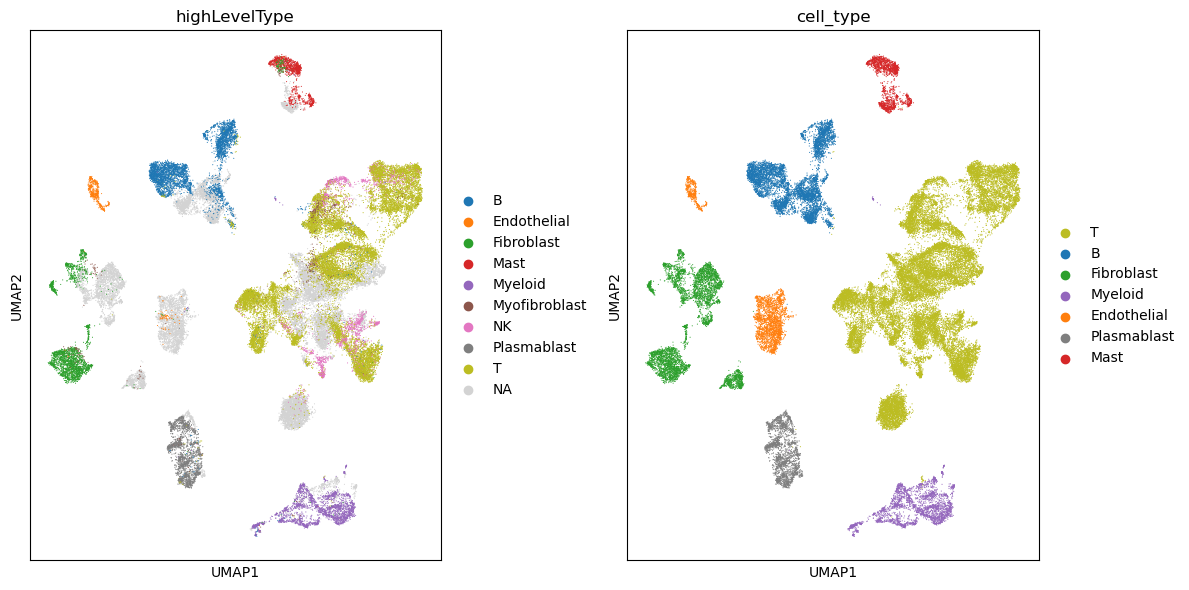

In [32]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.model_selection import train_test_split
from scipy.sparse import issparse
import matplotlib.pyplot as plt

print("Starting enhanced clustering script.")

# Load data
print("Loading datasets.")
train_adata = sc.read_h5ad('train_adata.h5ad')
test_adata = sc.read_h5ad('test_adata.h5ad')

# Check shapes, cell names
print(f"train_adata shape: {train_adata.shape}")
print(f"test_adata shape: {test_adata.shape}")
print(f"train_adata cell names (first 5): {train_adata.obs_names[:5]}")
print(f"test_adata cell names (first 5): {test_adata.obs_names[:5]}")

# Prefix names for uniqueness
train_adata.obs_names = ['train_' + str(i) for i in train_adata.obs_names]
test_adata.obs_names = ['test_' + str(i) for i in test_adata.obs_names]

# Verify new names
print(f"Updated train_adata cell names (first 5): {train_adata.obs_names[:5]}")
print(f"Updated test_adata cell names (first 5): {test_adata.obs_names[:5]}")

# Add batch info
train_adata.obs['batch'] = 'train'
test_adata.obs['batch'] = 'test'

# Check 'highLevelType'
if 'highLevelType' not in train_adata.obs.columns:
    raise ValueError("'highLevelType' column not found in train_adata.obs")
else:
    print("'highLevelType' found in train_adata.obs")

# Assign NaN to test
test_adata.obs['highLevelType'] = pd.NA

# Concatenate datasets
adata = sc.concat([train_adata, test_adata], join='outer', label='batch', keys=['train', 'test'], index_unique=None)

# Check concatenated data
print(f"\nadata shape after concatenation: {adata.shape}")
print("Columns in adata.obs after concat:", adata.obs.columns.tolist())
print("First 5 cells in adata.obs:")
print(adata.obs.head())

# Map 'highLevelType'
train_highLevelType_mapping = train_adata.obs['highLevelType'].to_dict()
adata.obs['highLevelType'] = adata.obs_names.map(train_highLevelType_mapping)

# Verify mapping
print("\nUnique 'highLevelType' after mapping:", adata.obs['highLevelType'].unique())
print(f"Training cells with 'highLevelType': {adata.obs['highLevelType'].notna().sum()}")

# Mito fraction
print("Calculating mito fraction.")
mito_genes = adata.var_names.str.startswith('MT-') | adata.var_names.str.startswith('mt-')
mito_counts = adata[:, mito_genes].X.sum(axis=1)
total_counts = adata.X.sum(axis=1)

if issparse(adata.X):
    mito_counts = mito_counts.A1 if hasattr(mito_counts, 'A1') else mito_counts.toarray().flatten()
    total_counts = total_counts.A1 if hasattr(total_counts, 'A1') else total_counts.toarray().flatten()
else:
    mito_counts = mito_counts.flatten()
    total_counts = total_counts.flatten()

finite_mask = np.isfinite(mito_counts) & np.isfinite(total_counts) & (total_counts != 0)
num_infinite = (~finite_mask).sum()
if num_infinite > 0:
    print(f"Found {num_infinite} cells with non-finite mito or total counts. Set to zero.")
    mito_counts[~finite_mask] = 0
    total_counts[~finite_mask] = 1

adata.obs['percent_mito'] = mito_counts / total_counts

print(f"Mean mito: {adata.obs['percent_mito'].mean():.4f}")
print(f"Median mito: {adata.obs['percent_mito'].median():.4f}")
print(f"Max mito: {adata.obs['percent_mito'].max():.4f}")

# Normalize, log
print("Normalizing to 10k and log-transform.")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Verify norm
if issparse(adata.X):
    sum_counts = adata.X[:5, :].sum(axis=1).A1
else:
    sum_counts = adata.X[:5, :].sum(axis=1)
print("Sum counts after norm (first 5):", sum_counts[:5])

# Highly variable genes
print("Selecting HVGs (top 2000) with Seurat v3.")
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, batch_key='batch')

# Check HVGs
print(f"Number of HVGs: {adata.var.highly_variable.sum()}")

# Use HVGs
adata = adata[:, adata.var.highly_variable].copy()

# Check for inf/nan before scaling
print("\nChecking inf/nan before scaling and batch correction...")
if issparse(adata.X):
    has_inf = np.isinf(adata.X.data).any()
    has_nan = np.isnan(adata.X.data).any()
else:
    has_inf = np.isinf(adata.X).any()
    has_nan = np.isnan(adata.X).any()

print(f"Contains inf: {has_inf}")
print(f"Contains nan: {has_nan}")

if has_inf or has_nan:
    print("Replacing inf/nan with zeros.")
    if issparse(adata.X):
        adata.X.data[np.isinf(adata.X.data) | np.isnan(adata.X.data)] = 0
    else:
        adata.X[np.isinf(adata.X) | np.isnan(adata.X)] = 0

# Scale
print("Scaling data: mean 0, var 1, clip at 10.")
sc.pp.scale(adata, max_value=10)

# Verify scaling
if issparse(adata.X):
    scaled_means = adata.X[:5, :].mean(axis=1).A1
    scaled_vars = adata.X[:5, :].var(axis=1).A1
else:
    scaled_means = adata.X[:5, :].mean(axis=1)
    scaled_vars = adata.X[:5, :].var(axis=1)
print(f"Scaled means (first 5): {scaled_means}")
print(f"Scaled vars (first 5): {scaled_vars}")

# Batch correction
print("Applying ComBat for batch correction.")
sc.pp.combat(adata, key='batch')

# Check after ComBat
print("\nChecking inf/nan after ComBat...")
if issparse(adata.X):
    has_inf = np.isinf(adata.X.data).any()
    has_nan = np.isnan(adata.X.data).any()
else:
    has_inf = np.isinf(adata.X).any()
    has_nan = np.isnan(adata.X).any()

print(f"Contains inf after ComBat: {has_inf}")
print(f"Contains nan after ComBat: {has_nan}")

if has_inf or has_nan:
    print("Replacing inf/nan post ComBat.")
    if issparse(adata.X):
        adata.X.data[np.isinf(adata.X.data) | np.isnan(adata.X.data)] = 0
    else:
        adata.X[np.isinf(adata.X) | np.isnan(adata.X)] = 0

# PCA
print("Running PCA.")
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

# Check PCA
print(f"PCA components shape: {adata.obsm['X_pca'].shape}")

# Neighbors
print("Calculating neighbors.")
sc.pp.neighbors(adata, n_pcs=50, n_neighbors=15, use_rep='X_pca')

# UMAP
print("Running UMAP.")
sc.tl.umap(adata, min_dist=0.3)

# Check UMAP
print(f"UMAP shape: {adata.obsm['X_umap'].shape}")

# Clustering
print("Leiden clustering with various resolutions.")
best_ari = 0
best_resolution = None
resolutions = np.arange(0.01, 0.1, 0.01)

train_mask = (adata.obs['batch'] == 'train') & (adata.obs['highLevelType'].notna())
true_labels = adata.obs['highLevelType'][train_mask]

print(f"\nTraining cells for eval: {len(true_labels)}")
print("True labels:", true_labels.unique())

for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')
    pred_labels = adata.obs[f'leiden_{res}'][train_mask]
    
    ari = adjusted_rand_score(true_labels, pred_labels)
    v_measure = v_measure_score(true_labels, pred_labels)
    print(f"Res {res:.2f}: ARI={ari:.4f}, V-measure={v_measure:.4f}")
    
    if ari > best_ari:
        best_ari = ari
        best_resolution = res

if best_resolution is not None:
    print(f"Best ARI: {best_ari:.4f} at res {best_resolution:.2f}")
    adata.obs['leiden'] = adata.obs[f'leiden_{best_resolution}']
else:
    raise ValueError("No suitable resolution based on ARI.")

print("Mapping clusters to cell types.")

train_data = adata[train_mask].obs[['leiden', 'highLevelType']]
cluster_to_celltype = train_data.groupby('leiden')['highLevelType'].agg(lambda x: x.value_counts().idxmax()).to_dict()

print(f"Cluster to cell type: {cluster_to_celltype}")

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_to_celltype)

# Assign to test
print("Assigning cell types to test data.")
test_mask = adata.obs['batch'] == 'test'
test_clusters = adata.obs['leiden'][test_mask]
test_indices = adata.obs_names[test_mask]
test_cell_types = test_clusters.map(cluster_to_celltype)

# Remove prefix
test_cell_names = test_indices

# Factorize
cluster_ids, unique_cell_types = pd.factorize(test_cell_types)
cluster_ids += 1  # Start at 1

# Create DataFrame
cluster_membership = pd.DataFrame({
    'index': test_cell_names,  # Clean names
    'cluster': cluster_ids     # IDs
})

# Order cols
cluster_membership = cluster_membership[['index', 'cluster']]

cluster_membership['index'] = cluster_membership['index'].str.replace('^test_', '', regex=True)

# Verify
print("\nCluster Membership (first 5):")
print(cluster_membership.head())

# Save CSV
cluster_membership.to_csv('cluster_membership.csv', index=True)
print("Saved 'cluster_membership.csv'.")
print("Clustering done.")

# Colors
cell_type_colors = {
    'B': '#1f77b4',
    'Endothelial': '#ff7f0e',
    'Fibroblast': '#2ca02c',
    'Mast': '#d62728',
    'Myeloid': '#9467bd',
    'Myofibroblast': '#8c564b',
    'NK': '#e377c2',
    'Plasmablast': '#7f7f7f',
    'T': '#bcbd22',
    'NA': '#17becf'
}

# Plot UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sc.pl.umap(
    adata, 
    color='highLevelType', 
    palette=cell_type_colors, 
    ax=axes[0], 
    show=False, 
    title='highLevelType'
)
sc.pl.umap(
    adata, 
    color='cell_type', 
    palette=cell_type_colors, 
    ax=axes[1], 
    show=False, 
    title='cell_type'
)
plt.tight_layout()
plt.show()


# Step 2bis: Predict on the test data

In [ ]:
# Use the same clustering technique to cluster the test data 

# Step 3: Save the required files

In [52]:
pred_props

,Unnamed: 0,s5_0,s5_1,s5_2,s5_3,s5_4,s6_0,s6_1,s6_2,s6_3,...,s9_0,s9_1,s9_2,s9_3,s9_4,s10_0,s10_1,s10_2,s10_3,s10_4
0,T,0.105103,0.498989,0.438723,0.406354,0.487964,0.533413,0.560869,0.546053,0.537088,...,0.507542,0.490958,0.497013,0.507591,0.519986,0.548221,0.579507,0.544394,0.557450,0.541455
1,Endothelial,0.065935,0.044114,0.046097,0.051268,0.040870,0.048992,0.043806,0.041408,0.047589,...,0.056063,0.061404,0.059255,0.057557,0.055007,0.061916,0.059215,0.064915,0.064041,0.062359
2,Fibroblast,0.000000,0.072899,0.059647,0.055310,0.068845,0.074517,0.077954,0.077386,0.076729,...,0.082844,0.073822,0.075529,0.077199,0.085061,0.075145,0.078716,0.074873,0.075169,0.076258
3,Plasmablast,0.059543,0.007315,0.029413,0.022601,0.015366,0.004710,0.007048,0.007025,0.006178,...,0.003933,0.002056,0.004946,0.007579,0.004477,0.006877,0.006819,0.009723,0.017760,0.002291
4,B,0.537366,0.247423,0.287958,0.306430,0.266088,0.217788,0.198463,0.208218,0.207420,...,0.237750,0.264328,0.242569,0.229295,0.213826,0.205509,0.182750,0.203864,0.170039,0.214772
5,Myofibroblast,0.089495,0.069981,0.063107,0.074142,0.059956,0.061939,0.069489,0.067549,0.067766,...,0.077624,0.062279,0.072141,0.073132,0.081015,0.073752,0.070635,0.073292,0.073116,0.077317
6,NK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Myeloid,0.142559,0.047065,0.063201,0.079515,0.044300,0.031689,0.031549,0.036799,0.038376,...,0.034244,0.027767,0.041642,0.044700,0.040629,0.028581,0.022358,0.028940,0.042425,0.023219
8,Mast,0.000000,0.012215,0.011854,0.004380,0.016612,0.026952,0.010821,0.015562,0.018854,...,0.000000,0.017385,0.006906,0.002947,0.000000,0.000000,0.000000,0.000000,0.000000,0.002329


In [6]:
cluster_labels = pd.read_csv('cluster_membership.csv', index_col=None)
cluster_labels = cluster_labels.drop(cluster_labels.columns[0], axis=1)
pred_props = pd.read_csv('pred_props.csv', index_col=None)
pred_props = pred_props.drop(pred_props.columns[0], axis=1)

In [7]:
cluster_labels

,index,cluster
0,AAACCCAAGGAGGCAG-1_5,1
1,AAACCCAAGTTGCGCC-1_5,1
2,AAACCCACACGGATCC-1_5,1
3,AAACCCACATCGGAAG-1_5,1
4,AAACCCAGTGCGAGTA-1_5,1
...,...,...
18611,TTTGGTTCATTGAAGA-1_10,1
18612,TTTGGTTGTTGTCCCT-1_10,2
18613,TTTGGTTGTTTGACAC-1_10,1
18614,TTTGTTGAGGGTCAAC-1_10,1


In [8]:
pred_props

,index,s5_0,s5_1,s5_2,s5_3,s5_4,s6_0,s6_1,s6_2,s6_3,...,s9_0,s9_1,s9_2,s9_3,s9_4,s10_0,s10_1,s10_2,s10_3,s10_4
0,T,0.105103,0.498989,0.438723,0.406354,0.487964,0.533413,0.560869,0.546053,0.537088,...,0.507542,0.490958,0.497013,0.507591,0.519986,0.548221,0.579507,0.544394,0.557450,0.541455
1,Endothelial,0.065935,0.044114,0.046097,0.051268,0.040870,0.048992,0.043806,0.041408,0.047589,...,0.056063,0.061404,0.059255,0.057557,0.055007,0.061916,0.059215,0.064915,0.064041,0.062359
2,Fibroblast,0.000000,0.072899,0.059647,0.055310,0.068845,0.074517,0.077954,0.077386,0.076729,...,0.082844,0.073822,0.075529,0.077199,0.085061,0.075145,0.078716,0.074873,0.075169,0.076258
3,Plasmablast,0.059543,0.007315,0.029413,0.022601,0.015366,0.004710,0.007048,0.007025,0.006178,...,0.003933,0.002056,0.004946,0.007579,0.004477,0.006877,0.006819,0.009723,0.017760,0.002291
4,B,0.537366,0.247423,0.287958,0.306430,0.266088,0.217788,0.198463,0.208218,0.207420,...,0.237750,0.264328,0.242569,0.229295,0.213826,0.205509,0.182750,0.203864,0.170039,0.214772
5,Myofibroblast,0.089495,0.069981,0.063107,0.074142,0.059956,0.061939,0.069489,0.067549,0.067766,...,0.077624,0.062279,0.072141,0.073132,0.081015,0.073752,0.070635,0.073292,0.073116,0.077317
6,NK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Myeloid,0.142559,0.047065,0.063201,0.079515,0.044300,0.031689,0.031549,0.036799,0.038376,...,0.034244,0.027767,0.041642,0.044700,0.040629,0.028581,0.022358,0.028940,0.042425,0.023219
8,Mast,0.000000,0.012215,0.011854,0.004380,0.016612,0.026952,0.010821,0.015562,0.018854,...,0.000000,0.017385,0.006906,0.002947,0.000000,0.000000,0.000000,0.000000,0.000000,0.002329


In [ ]:
# pred_props should be a DataFrame containing the estimated cell type proportions for the patients in all_bulkified
# pred_props.columns = ['index','s5_0','s5_1',...,'s10_3','s10_4'] = np.append(["index"],all_bulkified.columns)
# pred_props['index'] = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
#       'NK', 'Myeloid', 'Mast']

In [9]:
results_path = pl.Path("")

In [10]:
assert all(pred_props.columns == np.append(["index"],all_bulkified.columns)), "Wrong columns"

In [11]:
assert all(pred_props['index']== ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
       'NK', 'Myeloid', 'Mast']), "Wrong order for cell types"

In [12]:
assert all(pred_props.drop("index",axis=1).sum().round()==1), "The proportions for a single patient must sum to 1"

In [78]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = test_adata.columns

In [13]:
assert all(cluster_labels.columns == ["index", "cluster"]), "Wrong columns"

In [18]:
assert all(cluster_labels["index"] == test_adata.obs_names), "The cell ids are either not all present or not in the right order"

In [20]:
import zipfile

archive_name = "LastName_FirstName_Project2.zip" # TODO

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    with zf.open(f"pred_props.csv", "w") as buffer:
        pred_props.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    zf.close()